### Creating a class for the project

In [105]:
class mnist_nn:
  def __init__(self):
    ''' The init function would read the dataset from sklearn datasets and print its shape'''
    from keras.datasets import mnist
    (self.x_train,self.y_train),(self.x_test,self.y_test)=mnist.load_data()
    print('Size of Train data : ',self.x_train.shape)
    print('Size of Test data : ',self.x_test.shape)
    self.combine_x=[self.x_train,self.x_test]
    self.combine_y=[self.y_train,self.y_test]
  

  def ohe_outputs(self,combine_y):
    ''' The function would one hot encode the outputs of the mnist dataset '''
    import numpy as np
    self.combine_ohe=[]
    for data_y in combine_y:
      result=np.zeros((data_y.shape[0],10))
      for i in range(data_y.shape[0]):
        result[i][data_y[i]]=1
      self.combine_ohe.append(np.array(result))
    self.combine_ohe=np.array(self.combine_ohe)

  

  def ohe_two_class(self,combine_y):
    ''' The function would one hot encode the outputs of the mnist dataset '''
    import numpy as np
    self.combine_ohe=[]
    for data_y in combine_y:
      result=np.zeros((data_y.shape[0],2))
      for i in range(data_y.shape[0]):
        result[i][int(data_y[i])]=1
      self.combine_ohe.append(np.array(result))
    self.ohe_two_classes=np.array(self.combine_ohe)



  def image_normalisation(self):
    ''' Dividing all pixel images by 255 to normalise it '''
    self.combine_x[0]=self.combine_x[0]/255
    self.combine_x[1]=self.combine_x[1]/255
    print('Image Normalization done')



  def create_best_model(self,epochs=10):
    ''' Creating the best model with all the data to get the best
    fit model so as to label the data produced by GAN'''
    import keras
    from keras import Sequential
    from keras.layers import Flatten,Dense

    model=keras.Sequential()
    model.add(Flatten(input_shape=(28,28)))
    model.add(Dense(512,activation='relu'))
    model.add(Dense(256,activation='relu'))
    model.add(Dense(128,activation='relu'))
    model.add(Dense(64,activation='relu'))
    model.add(Dense(32,activation='relu'))
    model.add(Dense(10,activation='softmax'))
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    model.fit(self.combine_x[0],self.combine_ohe[0],validation_data=(self.combine_x[1],self.combine_ohe[1]),epochs=epochs,verbose=1)
    self.model=model




  def convert_to_n_class(self):
    ''' Converts the MNIST into a 2 class classification problem by 5 and not 5'''
    # Step 1 : Combine the data
    import numpy as np
    self.combine_x=np.concatenate([self.combine_x[0],self.combine_x[1]])
    self.combine_y=np.concatenate([self.combine_y[0],self.combine_y[1]])
    self.gan_train=self.combine_x[np.where(self.combine_y==5)]
    # Check for the number of 5's and not 5's 
    print('The number of images with class "5" : ', self.combine_y[np.where(self.combine_y==5)].shape)
    print('The number of images with class "NOT 5" : ',self.combine_y[np.where(self.combine_y!=5)].shape)
    # Dropping 95% of the data
    #Randomly selecting 5% of the index
    fivePct=(self.combine_y[np.where(self.combine_y==5)].shape[0]*5)//100
    index=np.arange(0,self.combine_y[np.where(self.combine_y==5)].shape[0])
    import random
    five_pct_index=random.sample(set(index),fivePct)


    # Step 2: Creating a subset by dropping 5% of the class "5" whie keeping all elements
    #thus creating an imbalance
    print('\nRandom sampling to select 5% of the data from class 5 keeping the rest \n')
    self.x_subset_of_5_class=self.combine_x[np.where(self.combine_y==5)][five_pct_index]
    # y_subset_of_5_class=self.combine_y[np.where(self.combine_y==5)][five_pct_index]
    y_subset_of_5_class=np.ones(self.x_subset_of_5_class.shape[0])
    x_subset_of_not_5_class=self.combine_x[np.where(self.combine_y!=5)]
    # y_subset_of_not_5_class=self.combine_y[np.where(self.combine_y!=5)]
    y_subset_of_not_5_class=np.zeros(x_subset_of_not_5_class.shape[0])

    self.subset_x=np.concatenate([self.x_subset_of_5_class,x_subset_of_not_5_class])
    self.subset_y=np.concatenate([y_subset_of_5_class,y_subset_of_not_5_class])

    print('The number of images with class "5" : ', self.subset_y[np.where(mnist.subset_y==1)].shape)
    print('The number of images with class "NOT 5" : ',self.subset_y[np.where(mnist.subset_y!=1)].shape)
    print(self.subset_y.shape)


    print('Shuffling the data to make sure that there is no specific patterns')
    # Creating an index and shuffling it 
    index=np.arange(0,self.subset_y.shape[0])
    random.shuffle(index)
    self.subset_x=self.subset_x[index]
    self.subset_y=self.subset_y[index]
  

    # Printing the data to verify that we havent lost any data during the process
    # print('The number of images with class "5" : ', mnist.subset_y[np.where(mnist.subset_y==5)].shape)
    # print('The number of images with class "NOT 5" : ',mnist.subset_y[np.where(mnist.subset_y!=5)].shape)




  def model_with_unbalanced_data(self,x_data,y_data,epochs=30):
    ''' Creating a model with the unbalanced dataset to see the performance '''
    import keras
    from keras import Sequential
    from keras.layers import Flatten,Dense

    model=keras.Sequential()
    model.add(Flatten(input_shape=(28,28)))
    model.add(Dense(16,activation='sigmoid'))
    model.add(Dense(1,activation='sigmoid'))
    model.add(Dense(2,activation='softmax'))
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    # Stratified Split with 80%
    from sklearn.model_selection import train_test_split
    x_train,x_test,y_train,y_test=train_test_split(x_data,y_data,stratify=y_data,test_size=20)

    self.ohe_two_class([y_train,y_test]) #One hot encoding the labels
    y_train,y_test=self.ohe_two_classes

    model.fit(x_train,y_train,epochs=epochs,verbose=1)
    self.unbalanced_model=model
    print('Done training the model')


  def print_data(self,data,labels,number=4):
    ''' Fcuntion to print the data alomg with the labels for testing purposes'''
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10,10))
    plot_count=1
    for i in range(number):
      plt.subplot(1,number,plot_count)
      plt.title(str(labels[i]))
      plt.imshow(data[i].reshape(28,28))
      plot_count+=1



Size of Train data :  (60000, 28, 28)
Size of Test data :  (10000, 28, 28)
One Hot Encoding the labels

Normalizing the images

Image Normalization done
Creating the best model with entire data

Converting the problem into a 2 stage classification problem

The number of images with class "5" :  (6313,)
The number of images with class "NOT 5" :  (63687,)

Random sampling to select 5% of the data from class 5 keeping the rest 

The number of images with class "5" :  (315,)
The number of images with class "NOT 5" :  (63687,)
(64002,)
Shuffling the data to make sure that there is no specific patterns
Printing the data and labels for testing

Unbalancing the data and retraining the model with new data
Epoch 1/10
2000/2000 [==============================] - 6s 3ms/step - loss: 0.0892 - accuracy: 0.9951
Epoch 2/10
2000/2000 [==============================] - 6s 3ms/step - loss: 0.0326 - accuracy: 0.9951
Epoch 3/10
2000/2000 [==============================] - 6s 3ms/step - loss: 0.0311 - accur

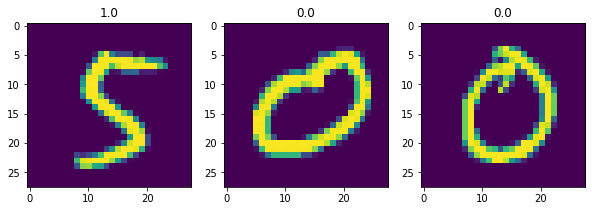

In [106]:
# Turning off the warnings
import warnings
warnings.filterwarnings('ignore')

mnist=mnist_nn()
# Operations on image
print('One Hot Encoding the labels\n')
mnist.ohe_outputs(mnist.combine_y) # One Hot Encoding the Y values
print('Normalizing the images\n')
mnist.image_normalisation() # Normalising the pixels in image
print('Creating the best model with entire data\n')
#mnist.create_best_model(20) # Creating the best model from the available data which will later be used for labelling the images produced by the GAN
print('Converting the problem into a 2 stage classification problem\n')
mnist.convert_to_n_class()
print('Printing the data and labels for testing\n')
mnist.print_data(mnist.subset_x,mnist.subset_y,3)
print('Unbalancing the data and retraining the model with new data')
mnist.model_with_unbalanced_data(mnist.subset_x,mnist.subset_y,10)
print('Process completed')

# Creating a class for GAN
Reference : Intro to GAN video series by Dr Sunil Kumar Vuppala

In [35]:
class gan:
  def __init__(self):
    """ The function will check if there is a pretrained model already in the 
    folder. If found, it will load the data. Otherwise, it will return error message"""

    print('Class initialized')
    import os
    from keras.models import  load_model
    flag=0
    for file in os.listdir():
      if file=='mnist_generator_dcgan.h5':
        self.model=load_model(file)
        print('Pre trained model loaded')
        flag=1
    if flag==0:
      print('Pre trained model not found')
            
  

  def create_generator(self,image_size=28,input_size=100):
    ''' The function creates a generative model use=ing Keras and returns the model
    The image is first converted into a smaller dimension with more channels. 
    Once this is done, we use futher Conv2D transpose operation to increase the size of the imahe
    and to decrese the number of channels.
    After the process, the model ends up creating an image of size 28x28 in the last layer. 
    '''

    import keras 
    import tensorflow as tf
    #Build an input layer
    gen_input = tf.keras.layers.Input(shape=(input_size,))
    
    #Increase dimensions and resize to 3D to feed it to Conv2DTranspose layer
    x = tf.keras.layers.Dense(7 * 7 * 128)(gen_input)
    x = tf.keras.layers.Reshape((7, 7, 128))(x)
    
    #Use ConvTranspose
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2DTranspose(128, kernel_size=[5,5], strides=2, padding='same')(x)
    
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2DTranspose(64, kernel_size=[5,5], strides=2, padding='same')(x)
    
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2DTranspose(32, kernel_size=[5,5], strides=1, padding='same')(x)
    
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2DTranspose(1, kernel_size=[5,5], strides=1, padding='same')(x)
    
    #Output layer for Generator
    x = tf.keras.layers.Activation('sigmoid')(x)
    
    #Build model using Model API
    generator = tf.keras.models.Model(gen_input, x, name='generator')
    
    return generator

    
  def create_discriminator(self,shape=[28,28,1,]):
      """ Function to build the discriminator network from scratch using the tensorflow 
      and keras libraries"""
      import tensorflow as tf
      #Build the network
      dis_input = tf.keras.layers.Input(shape)
      x = tf.keras.layers.LeakyReLU(alpha=0.2)(dis_input)
      x = tf.keras.layers.Conv2D(32, kernel_size=[5,5], strides=2, padding='same')(x)
      
      x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
      x = tf.keras.layers.Conv2D(64, kernel_size=[5,5], strides=2, padding='same')(x)
      
      x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
      x = tf.keras.layers.Conv2D(128, kernel_size=[5,5], strides=2, padding='same')(x)
      
      x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
      x = tf.keras.layers.Conv2D(256, kernel_size=[5,5], strides=1, padding='same')(x)
      
      #Flatten the output and build an output layer
      x = tf.keras.layers.Flatten()(x)
      x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
      
      #Build Model
      discriminator = tf.keras.models.Model(dis_input, x, name='discriminator')
      
      return discriminator



  def build_model(self):
    """ The function creates a GAN model by using the discrimnator and generator models which were
    defined in the earlier funtions inside the class. It also returns the generator, disciminator and 
    adversarial network after creating the model"""
    import tensorflow as tf

    noise_size = 100
    lr = 2e-4
    decay = 6e-8
    
    #Build Base Discriminator model
    base_discriminator = self.create_discriminator()
    
    #Define optimizer and compile model
    discriminator = tf.keras.models.Model(inputs=base_discriminator.inputs, 
                                          outputs=base_discriminator.outputs)
    optimizer = tf.keras.optimizers.RMSprop(lr=lr, decay=decay)
    discriminator.compile(loss='binary_crossentropy',
                          optimizer=optimizer,
                          metrics=['accuracy'])
    
    #Build Generator model
    generator = self.create_generator(image_size=28, input_size=noise_size)
    
    #Build Frozen Discriminator
    frozen_discriminator = tf.keras.models.Model(inputs=base_discriminator.inputs, 
                                          outputs=base_discriminator.outputs)
    #Freeze the weights of discriminator during adversarial training
    frozen_discriminator.trainable = False

    #Build Adversarial model
    optimizer = tf.keras.optimizers.RMSprop(lr=lr * 0.5, decay=decay * 0.5)
    #Adversarial = generator + discriminator
    adversarial = tf.keras.models.Model(generator.input, 
                        frozen_discriminator(generator.output))
    
    adversarial.compile(loss='binary_crossentropy',
                        optimizer=optimizer,
                        metrics=['accuracy'])    
    
    return generator, discriminator, adversarial





  def train_gan(self,generator,discriminator,adversarial_network,distribution_size=100):
    import tensorflow as tf
    import numpy as np
    #Training parameters
    batch_size = 64
    train_steps = 3000
    image_size = 28
    
    # load MNIST dataset
    (train_x, train_y), (_, _) = tf.keras.datasets.mnist.load_data()
    train_x=train_x[np.where(train_y==5)]
    #Make it 3D dataset
    train_x = np.reshape(train_x, [-1, image_size, image_size, 1])
    #Standardize data : 0 to 1
    train_x = train_x.astype('float32') / 255
    
    #Input for testing generator at different intervals, we will generate 16 images
    test_noise_input = np.random.uniform(-1.0,1.0, size=[16, distribution_size])
    
    #Start training
    for i in range(train_steps):
        
        #Train DISCRIMATOR
        
        #1. Get fake images from Generator
        noise_input = np.random.uniform(-1.0,1.0, size=[batch_size, distribution_size])
        fake_images = generator.predict(noise_input)
        
        #2. Get real images from training set
        img_indexes = np.random.randint(0, train_x.shape[0], size=batch_size)
        real_images = train_x[img_indexes]
        
        #3. Prepare input for training Discriminator
        X = np.concatenate((real_images, fake_images))
        
        #4. Labels for training
        y_real = np.ones((batch_size, 1))
        y_fake = np.zeros((batch_size, 1))
        y = np.concatenate((y_real, y_fake))
        
        #5. Train Discriminator
        d_loss, d_acc = discriminator.train_on_batch(X, y)
        
        
        #Train ADVERSARIAL Network
        
        #1. Prepare input - create a new batch of noise
        X = noise_input = np.random.uniform(-1.0,1.0, size=[batch_size, distribution_size])
        
        #2. Prepare labels - training Adversarial network to lie :) - All 1s
        y = np.ones((batch_size, 1))
        
        #3. Train - Pls note Discrimator is not getting trained here
        a_loss, a_acc = adversarial_network.train_on_batch(X, y)
        
        if i % 100 == 0:
            #Print loss and Accuracy for both networks
            print("%s [Discriminator loss: %f, acc: %f, Adversarial loss: %f, acc: %f]" % (i, d_loss, d_acc, a_loss, a_acc) )
        
        #Save generated images to see how well Generator is doing
        if (i+1) % 500 == 0:
            
            #Generate 16 images
            fake_images = generator.predict(test_noise_input)
            
            #Display images
            self.plot_images(fake_images, i+1)
            
    #Save Generator model
    self.model=generator
    generator.save('mnist_generator_dcgan.h5')   




  def plot_images(self,fake_images, step):
    '''  The function helps in plotting the graphs, so that it is easy to 
    see how the model trains '''
    
    import matplotlib.pyplot as plt
    import math
    import numpy as np
    plt.figure(figsize=(2.5,2.5))
    num_images = fake_images.shape[0]
    
    image_size = fake_images.shape[1]
    rows = int(math.sqrt(fake_images.shape[0]))
    
    for i in range(num_images):
        plt.subplot(rows, rows, i + 1)
        image = np.reshape(fake_images[i], [image_size, image_size])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.show()

  def generate_fives(self,number):
    ''' This function will generate 'number' number of 5's and will return the array'''
    noise_input = np.random.uniform(-1.0,1.0, size=[number, 100])
    fake_images = self.model.predict(noise_input)
    return fake_images


## Calling the GAN functions

In [36]:
gan_object=gan()
Generator,Discriminator,Adversarial=gan_object.build_model()


Class initialized
Pre trained model loaded


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


0 [Discriminator loss: 0.687856, acc: 0.679688, Adversarial loss: 0.848817, acc: 0.000000]
100 [Discriminator loss: 0.000038, acc: 1.000000, Adversarial loss: 0.000000, acc: 1.000000]
200 [Discriminator loss: 0.000373, acc: 1.000000, Adversarial loss: 0.106290, acc: 1.000000]
300 [Discriminator loss: 0.003436, acc: 1.000000, Adversarial loss: 0.047609, acc: 1.000000]
400 [Discriminator loss: 0.301678, acc: 0.843750, Adversarial loss: 0.000000, acc: 1.000000]


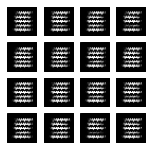

500 [Discriminator loss: 0.228673, acc: 0.960938, Adversarial loss: 4.786894, acc: 0.000000]
600 [Discriminator loss: 0.228241, acc: 0.906250, Adversarial loss: 3.494951, acc: 0.000000]
700 [Discriminator loss: 0.040532, acc: 0.976562, Adversarial loss: 0.003357, acc: 1.000000]
800 [Discriminator loss: 0.029547, acc: 1.000000, Adversarial loss: 0.006658, acc: 1.000000]
900 [Discriminator loss: 0.375752, acc: 0.804688, Adversarial loss: 0.012559, acc: 1.000000]


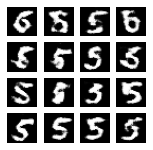

1000 [Discriminator loss: 0.576046, acc: 0.601562, Adversarial loss: 2.185865, acc: 0.000000]
1100 [Discriminator loss: 0.461206, acc: 0.789062, Adversarial loss: 1.018047, acc: 0.218750]
1200 [Discriminator loss: 0.594479, acc: 0.656250, Adversarial loss: 1.379464, acc: 0.078125]
1300 [Discriminator loss: 0.567171, acc: 0.703125, Adversarial loss: 0.847597, acc: 0.312500]
1400 [Discriminator loss: 0.717390, acc: 0.554688, Adversarial loss: 1.577986, acc: 0.015625]


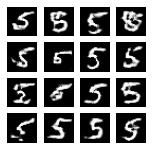

1500 [Discriminator loss: 0.618285, acc: 0.687500, Adversarial loss: 0.821590, acc: 0.437500]
1600 [Discriminator loss: 0.592905, acc: 0.664062, Adversarial loss: 0.670535, acc: 0.578125]
1700 [Discriminator loss: 0.551217, acc: 0.734375, Adversarial loss: 0.892329, acc: 0.359375]
1800 [Discriminator loss: 0.613282, acc: 0.671875, Adversarial loss: 0.982214, acc: 0.234375]
1900 [Discriminator loss: 0.622845, acc: 0.656250, Adversarial loss: 0.816269, acc: 0.390625]


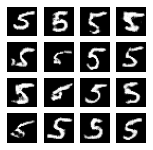

2000 [Discriminator loss: 0.596572, acc: 0.695312, Adversarial loss: 1.201578, acc: 0.062500]
2100 [Discriminator loss: 0.605983, acc: 0.640625, Adversarial loss: 0.865872, acc: 0.328125]
2200 [Discriminator loss: 0.634105, acc: 0.656250, Adversarial loss: 0.659659, acc: 0.593750]
2300 [Discriminator loss: 0.585616, acc: 0.710938, Adversarial loss: 1.131466, acc: 0.218750]
2400 [Discriminator loss: 0.638428, acc: 0.648438, Adversarial loss: 0.725652, acc: 0.421875]


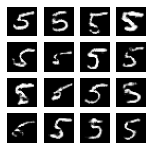

2500 [Discriminator loss: 0.618374, acc: 0.609375, Adversarial loss: 0.672269, acc: 0.578125]
2600 [Discriminator loss: 0.573686, acc: 0.703125, Adversarial loss: 0.863341, acc: 0.312500]
2700 [Discriminator loss: 0.618635, acc: 0.601562, Adversarial loss: 1.151710, acc: 0.125000]
2800 [Discriminator loss: 0.612720, acc: 0.625000, Adversarial loss: 0.727567, acc: 0.593750]
2900 [Discriminator loss: 0.633594, acc: 0.640625, Adversarial loss: 1.136072, acc: 0.187500]


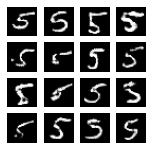

In [27]:
gan_object.train_gan(Generator,Discriminator,Adversarial)

# Synthetically generating images of 5


In [60]:
import numpy as np
fake_images=gan_object.generate_fives(63372)
fake_output=np.ones(63372)

In [73]:
# Joining with the existing dataset
x_train_1=mnist.subset_x
y_train_1=mnist.subset_y
x_train_2=fake_images
y_train_2=fake_output

# Concatenating the unbalanced data and the synthetically generated data
x_train=np.concatenate([x_train_1,np.squeeze(x_train_2)])
y_train=np.concatenate([y_train_1,y_train_2])

# Shuffling the dataset
import random
index=np.arange(0,y_train.shape[0])
random.shuffle(index)
x_train=x_train[index]
y_train=y_train[index]

# Training the same model with balanced data

In [107]:
mnist.model_with_unbalanced_data(x_train,y_train,10)

Epoch 1/10
3980/3980 [==============================] - 13s 3ms/step - loss: 0.2535 - accuracy: 0.9556
Epoch 2/10
3980/3980 [==============================] - 12s 3ms/step - loss: 0.0499 - accuracy: 0.9912
Epoch 3/10
3980/3980 [==============================] - 12s 3ms/step - loss: 0.0231 - accuracy: 0.9946
Epoch 4/10
3980/3980 [==============================] - 12s 3ms/step - loss: 0.0147 - accuracy: 0.9962
Epoch 5/10
3980/3980 [==============================] - 12s 3ms/step - loss: 0.0106 - accuracy: 0.9972
Epoch 6/10
3980/3980 [==============================] - 12s 3ms/step - loss: 0.0083 - accuracy: 0.9977
Epoch 7/10
3980/3980 [==============================] - 12s 3ms/step - loss: 0.0069 - accuracy: 0.9981
Epoch 8/10
3980/3980 [==============================] - 12s 3ms/step - loss: 0.0056 - accuracy: 0.9984
Epoch 9/10
3980/3980 [==============================] - 12s 3ms/step - loss: 0.0047 - accuracy: 0.9987
Epoch 10/10
3980/3980 [==============================] - 12s 3ms/step - l

## Comment on any differences that you saw in the two cases and generalize your comments on the utility of the approach above. (20 points)

When the data is trained after applying the steps as mentioned in the question, it will create an unbalanced dataset. 
The dataset has 315 data points belong to Class 5 and
63687 data points belng to Class NOT 5. 
Even if all the predictions are 0, there will be 99.995 % accuracy. 

After the data is generated and balanced after using synthesised data from GAN, we can see that the model starts from a higher loss than in the earlier case and then it converges to better accuracy. In this case the baseline accuracy is 50%. Hence the second model is a better solution. 


The above approach can help in Synthetic data generation, which helps in balancing unbalanced dataset. 
It can help in cases where the data collection is tricky or expensive. It also helps to ensure that the models created are much more efficient in production than a model which is trained using a unblanced dataset. 
